<a href="https://colab.research.google.com/github/seongyeon1/twitterNLP/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# DataFrame
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [96]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = 0
NEGATIVE = 1

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [97]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [98]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
DATA_IN_PATH = '/content/drive/MyDrive/ColabNotebooks/datasets/sentiments/'

In [101]:
df = pd.read_csv(DATA_IN_PATH + 'df_final.csv')

In [102]:
!pip install unidecode
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
!pip install wordninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import re
import unidecode
import numpy as np
import pandas as pd
import ktrain
from ktrain import text
import wordninja
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
df_train = df[:7920]
df_test = df[7920:]

In [106]:
df_train = df_train.dropna()

In [107]:
documents = [text.split() for text in df_train.tweet]

In [108]:
len(documents)

7919

In [109]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [110]:
w2v_model.build_vocab(documents)

words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

w2v_model.wv.most_similar("apple")

Vocab size 1490


[('suck', 0.4843127727508545),
 ('rid', 0.4514095187187195),
 ('making', 0.4378257095813751),
 ('tim', 0.4330400228500366),
 ('maps', 0.42184481024742126),
 ('imac', 0.4153698980808258),
 ('crappy', 0.41419559717178345),
 ('feature', 0.41338229179382324),
 ('huge', 0.41187721490859985),
 ('cook', 0.40991777181625366)]

In [111]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 10916
CPU times: user 243 ms, sys: 32.5 ms, total: 276 ms
Wall time: 280 ms


In [112]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.tweet), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.tweet), maxlen=SEQUENCE_LENGTH)

CPU times: user 262 ms, sys: 2.9 ms, total: 265 ms
Wall time: 351 ms


In [113]:
labels = df_train.label.unique().tolist()
labels

[0.0, 1.0]

In [114]:
sum(df_train.label == 0), sum(df_train.label == 1)

(5893, 2026)

In [115]:
df_test.label = df_test.label.fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [116]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (7919, 1)
y_test (1953, 1)


In [117]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(10916, 300)


In [118]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [119]:
model = Sequential()
model.add(tf.keras.layers.Embedding(1000, 300, input_length=300))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          300000    
                                                                 
 dropout_2 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 460,501
Trainable params: 460,501
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [121]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
pos = 5893
neg = 2026
total = neg + pos

weight_for_0 = 1/neg * total/2
weight_for_1 = 1/pos * total/2

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


class_weight 관련해서 : 

In [122]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
# print()
# print("ACCURACY:",score[1])
# print("LOSS:",score[0])

Epoch 1/10
72/72 [==============================] - 126s 2s/step - loss: 0.5038 - accuracy: 0.7653 - val_loss: 0.3963 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 2/10
72/72 [==============================] - 106s 1s/step - loss: 0.2716 - accuracy: 0.8597 - val_loss: 0.3034 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 3/10
72/72 [==============================] - 96s 1s/step - loss: 0.2423 - accuracy: 0.8844 - val_loss: 0.3397 - val_accuracy: 0.8485 - lr: 0.0010
Epoch 4/10
72/72 [==============================] - 93s 1s/step - loss: 0.2265 - accuracy: 0.8946 - val_loss: 0.3250 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 5/10
72/72 [==============================] - 94s 1s/step - loss: 0.2200 - accuracy: 0.9015 - val_loss: 0.3303 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 6/10
72/72 [==============================] - 94s 1s/step - loss: 0.2089 - accuracy: 0.9054 - val_loss: 0.3876 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 7/10
72/72 [==============================] - 93s 1s/step - loss: 0.2016 -

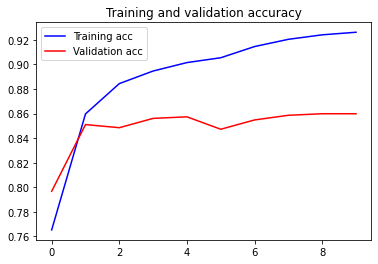

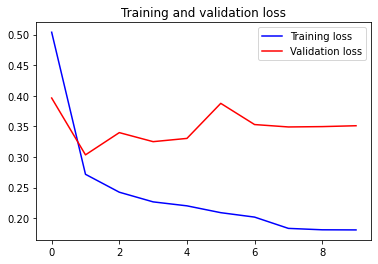

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [124]:
def decode_sentiment(score):
  return POSITIVE if score < 0.5 else NEGATIVE

In [125]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [126]:
predict("I don't love iphone")

{'elapsed_time': 0.40190553665161133,
 'label': 0,
 'score': 0.021053388714790344}

In [127]:
predict("I hate apple")

{'elapsed_time': 0.11361980438232422, 'label': 1, 'score': 0.7705164551734924}

In [128]:
%%time
y_pred_1d = []
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 436ms/step
CPU times: user 430 ms, sys: 58.4 ms, total: 488 ms
Wall time: 551 ms


In [129]:
submission = pd.read_csv((DATA_IN_PATH + 'sample_submission.csv'))

In [130]:
pd.DataFrame(scores).to_csv((DATA_IN_PATH + 'prediction_weight.csv'), index=False)

In [131]:
submission.label = y_pred_1d

In [132]:
submission.to_csv((DATA_IN_PATH + 'submission_weight.csv'), index=False) # 	0.865232286284918

In [133]:
df1 = pd.read_csv(DATA_IN_PATH + 'bert_preprocessed_2.csv')
df2 = pd.read_csv(DATA_IN_PATH + 'prediction_weight.csv')
df = ( df1 + df2*2 )/ 3

In [134]:
scores = df.iloc[:,0].values

In [135]:
pred = [decode_sentiment(score) for score in scores]

In [136]:
submission.label = pred
submission.to_csv((DATA_IN_PATH + 'submission_e2.csv'), index=False)